# Import Necessary Library

In [1]:
import time
from haversine_script import *
import numpy as np
import tensorflow as tf
import random
import pandas as p
import math
import matplotlib.pyplot as plt
import os
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation,BatchNormalization
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import Callback, TensorBoard, ModelCheckpoint, EarlyStopping
from keras import regularizers
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

Using TensorFlow backend.


# Dataset Preprocessing Functions

In [2]:
def get_exponential_distance(x,minimum,a=60):
	positive_x= x-minimum
	numerator = np.exp(positive_x.div(a))
	denominator = np.exp(-minimum/a)
	exponential_x = numerator/denominator
	exponential_x = exponential_x * 1000  #facilitating calculations
	final_x = exponential_x
	return final_x

In [3]:
def get_powed_distance(x,minimum,b=1.1):
	positive_x= x-minimum
	numerator = positive_x.pow(b)
	denominator = (-minimum)**(b)
	powed_x = numerator/denominator
	final_x = powed_x
	return final_x

# Python Random Seeding for experiment reproducibility

In [4]:
os.environ['PYTHONHASHSEED'] = "42"
np.random.seed(42)
tf.set_random_seed(42)
random.seed(42)

In [5]:

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1) 
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Loading Dataset

In [6]:
# reading the data
file = p.read_csv('lorawan_antwerp_2019_dataset.csv')
columns = file.columns
# x = file[columns[0:68]]
# y = file[columns[71:]]
x = file[columns[0:72]]
x = x.join(file[columns[73]])
y = file[columns[72:]]


Dataset Preprocessing

In [7]:
x = x.replace(-200,200)
minimum = x.min().min() - 1
x = x.replace(200,minimum)
print('minimum')
print(minimum)

minimum
-128.0


RSSI Data representation using Powed Function


In [8]:
final_x = get_powed_distance(x,minimum)

In [9]:
random_state = 42
x_train, x_test_val, y_train, y_test_val = train_test_split(final_x.values, y.values, test_size=0.3, random_state=random_state)
x_val, x_test, y_val, y_test = train_test_split(x_test_val, y_test_val, test_size=0.5, random_state=random_state)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(91300, 73)
(19564, 73)
(19565, 73)


In [10]:
n_of_features = x_train.shape[1]

scaler = preprocessing.MinMaxScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)


scaler_y = preprocessing.MinMaxScaler().fit(y_train)
y_train = scaler_y.transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)


# Network HyperParameters

In [11]:
dropout = 0.15
l2 = 0.00
lr = 0.0005
epochs = 10000
batch_size= 512
patience = 300

# Define the MLP Network

In [12]:
model = Sequential()
model.add(Dense(units=1024, input_dim=n_of_features, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout, seed=random_state))
model.add(Dense(units=1024, input_dim=n_of_features, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout, seed=random_state))
model.add(Dense(units=1024, input_dim=n_of_features, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout, seed=random_state))
model.add(Dense(units=256, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout, seed=random_state))
model.add(Dense(units=128, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout, seed=random_state))
model.add(Dense(units=128, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dropout(dropout))
model.add(Dense(units=2))
model.compile(loss='mean_absolute_error',optimizer=Adam(lr=lr))

W1124 07:51:15.605217 21156 deprecation_wrapper.py:119] From C:\Users\Paul Vincent Nonat\AppData\Local\conda\conda\envs\nonat_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1124 07:51:15.606213 21156 deprecation_wrapper.py:119] From C:\Users\Paul Vincent Nonat\AppData\Local\conda\conda\envs\nonat_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1124 07:51:15.615190 21156 deprecation_wrapper.py:119] From C:\Users\Paul Vincent Nonat\AppData\Local\conda\conda\envs\nonat_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1124 07:51:15.751824 21156 deprecation_wrapper.py:119] From C:\Users\Paul Vincent Nonat\AppData\Local\conda\conda\envs\nonat_gpu\lib\site-packages\keras\backend\tensorfl

In [13]:
cb =[EarlyStopping(monitor='val_loss', patience=patience, verbose =1, restore_best_weights=True)]
history = model.fit(x_train, y_train,validation_data=(x_val, y_val),epochs=epochs, batch_size=batch_size, verbose=1, callbacks= cb)


W1124 07:51:17.590934 21156 deprecation_wrapper.py:119] From C:\Users\Paul Vincent Nonat\AppData\Local\conda\conda\envs\nonat_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 91300 samples, validate on 19564 samples
Epoch 1/10000
91300/91300 [==============================] - 9s 100us/step - loss: 0.1431 - val_loss: 0.0514
Epoch 2/10000
91300/91300 [==============================] - 7s 73us/step - loss: 0.0547 - val_loss: 0.0376
Epoch 3/10000
91300/91300 [==============================] - 7s 75us/step - loss: 0.0467 - val_loss: 0.0412
Epoch 4/10000
91300/91300 [==============================] - 7s 72us/step - loss: 0.0412 - val_loss: 0.0369
Epoch 5/10000
91300/91300 [==============================] - 7s 73us/step - loss: 0.0396 - val_loss: 0.0413
Epoch 6/10000
91300/91300 [==============================] - 7s 73us/step - loss: 0.0377 - val_loss: 0.0254
Epoch 7/10000
91300/91300 [==============================] - 7s 74us/step - loss: 0.0364 - val_loss: 0.0289
Epoch 8/10000
91300/91300 [==============================] - 7s 75us/step - loss: 0.0344 - val_loss: 0.0263
Epoch 9/10000
91300/91300 [==============================] - 7s 74us/step - loss: 0.0

Epoch 76/10000
91300/91300 [==============================] - 7s 78us/step - loss: 0.0184 - val_loss: 0.0168
Epoch 77/10000
91300/91300 [==============================] - 7s 77us/step - loss: 0.0182 - val_loss: 0.0166
Epoch 78/10000
91300/91300 [==============================] - 7s 76us/step - loss: 0.0183 - val_loss: 0.0176
Epoch 79/10000
91300/91300 [==============================] - 7s 81us/step - loss: 0.0179 - val_loss: 0.0163
Epoch 80/10000
91300/91300 [==============================] - 8s 84us/step - loss: 0.0181 - val_loss: 0.0169
Epoch 81/10000
91300/91300 [==============================] - 8s 83us/step - loss: 0.0177 - val_loss: 0.0155
Epoch 82/10000
91300/91300 [==============================] - 7s 80us/step - loss: 0.0180 - val_loss: 0.0156
Epoch 83/10000
91300/91300 [==============================] - 7s 76us/step - loss: 0.0177 - val_loss: 0.0154
Epoch 84/10000
91300/91300 [==============================] - 7s 76us/step - loss: 0.0177 - val_loss: 0.0160
Epoch 85/10000
9130

91300/91300 [==============================] - 7s 81us/step - loss: 0.0140 - val_loss: 0.0151
Epoch 225/10000
91300/91300 [==============================] - 7s 78us/step - loss: 0.0141 - val_loss: 0.0158
Epoch 226/10000
91300/91300 [==============================] - 8s 87us/step - loss: 0.0141 - val_loss: 0.0161
Epoch 227/10000
91300/91300 [==============================] - 9s 95us/step - loss: 0.0139 - val_loss: 0.0148
Epoch 228/10000
91300/91300 [==============================] - 7s 76us/step - loss: 0.0142 - val_loss: 0.0159
Epoch 229/10000
91300/91300 [==============================] - 7s 76us/step - loss: 0.0141 - val_loss: 0.0147
Epoch 230/10000
91300/91300 [==============================] - 7s 76us/step - loss: 0.0140 - val_loss: 0.0141
Epoch 231/10000
91300/91300 [==============================] - 7s 76us/step - loss: 0.0140 - val_loss: 0.0141
Epoch 232/10000
91300/91300 [==============================] - 7s 76us/step - loss: 0.0139 - val_loss: 0.0148
Epoch 233/10000
91300/9130

91300/91300 [==============================] - 7s 80us/step - loss: 0.0128 - val_loss: 0.0137
Epoch 373/10000
91300/91300 [==============================] - 7s 79us/step - loss: 0.0128 - val_loss: 0.0136
Epoch 374/10000
91300/91300 [==============================] - 7s 80us/step - loss: 0.0128 - val_loss: 0.0143
Epoch 375/10000
91300/91300 [==============================] - 7s 79us/step - loss: 0.0126 - val_loss: 0.0145
Epoch 376/10000
91300/91300 [==============================] - 7s 79us/step - loss: 0.0127 - val_loss: 0.0145
Epoch 377/10000
91300/91300 [==============================] - 7s 78us/step - loss: 0.0128 - val_loss: 0.0138
Epoch 378/10000
91300/91300 [==============================] - 7s 79us/step - loss: 0.0128 - val_loss: 0.0137
Epoch 379/10000
91300/91300 [==============================] - 7s 79us/step - loss: 0.0127 - val_loss: 0.0147
Epoch 380/10000
91300/91300 [==============================] - 7s 81us/step - loss: 0.0128 - val_loss: 0.0135
Epoch 381/10000
91300/9130

91300/91300 [==============================] - 8s 88us/step - loss: 0.0120 - val_loss: 0.0134
Epoch 521/10000
91300/91300 [==============================] - 8s 86us/step - loss: 0.0120 - val_loss: 0.0138
Epoch 522/10000
91300/91300 [==============================] - 8s 84us/step - loss: 0.0120 - val_loss: 0.0140
Epoch 523/10000
91300/91300 [==============================] - 8s 85us/step - loss: 0.0120 - val_loss: 0.0134
Epoch 524/10000
91300/91300 [==============================] - 8s 87us/step - loss: 0.0121 - val_loss: 0.0138
Epoch 525/10000
91300/91300 [==============================] - 8s 84us/step - loss: 0.0122 - val_loss: 0.0140
Epoch 526/10000
91300/91300 [==============================] - 8s 85us/step - loss: 0.0119 - val_loss: 0.0140
Epoch 527/10000
91300/91300 [==============================] - 8s 84us/step - loss: 0.0120 - val_loss: 0.0141
Epoch 528/10000
91300/91300 [==============================] - 8s 84us/step - loss: 0.0120 - val_loss: 0.0133
Epoch 529/10000
91300/9130

91300/91300 [==============================] - 7s 77us/step - loss: 0.0116 - val_loss: 0.0139
Epoch 669/10000
91300/91300 [==============================] - 7s 77us/step - loss: 0.0115 - val_loss: 0.0140
Epoch 670/10000
91300/91300 [==============================] - 7s 77us/step - loss: 0.0115 - val_loss: 0.0132
Epoch 671/10000
91300/91300 [==============================] - 7s 77us/step - loss: 0.0116 - val_loss: 0.0133
Epoch 672/10000
91300/91300 [==============================] - 7s 79us/step - loss: 0.0114 - val_loss: 0.0135
Epoch 673/10000
91300/91300 [==============================] - 7s 80us/step - loss: 0.0114 - val_loss: 0.0133
Epoch 674/10000
91300/91300 [==============================] - 7s 77us/step - loss: 0.0115 - val_loss: 0.0139
Epoch 675/10000
91300/91300 [==============================] - 7s 77us/step - loss: 0.0115 - val_loss: 0.0136
Epoch 676/10000
91300/91300 [==============================] - 7s 81us/step - loss: 0.0115 - val_loss: 0.0134
Epoch 677/10000
91300/9130

91300/91300 [==============================] - 7s 76us/step - loss: 0.0112 - val_loss: 0.0130
Epoch 817/10000
91300/91300 [==============================] - 7s 76us/step - loss: 0.0111 - val_loss: 0.0136
Epoch 818/10000
91300/91300 [==============================] - 7s 77us/step - loss: 0.0112 - val_loss: 0.0134
Epoch 819/10000
91300/91300 [==============================] - 7s 76us/step - loss: 0.0113 - val_loss: 0.0133
Epoch 820/10000
91300/91300 [==============================] - 7s 77us/step - loss: 0.0111 - val_loss: 0.0138
Epoch 821/10000
91300/91300 [==============================] - 7s 78us/step - loss: 0.0112 - val_loss: 0.0132
Epoch 822/10000
91300/91300 [==============================] - 7s 78us/step - loss: 0.0111 - val_loss: 0.0134
Epoch 823/10000
91300/91300 [==============================] - 7s 78us/step - loss: 0.0112 - val_loss: 0.0139
Epoch 824/10000
91300/91300 [==============================] - 7s 78us/step - loss: 0.0111 - val_loss: 0.0131
Epoch 825/10000
91300/9130

91300/91300 [==============================] - 7s 77us/step - loss: 0.0109 - val_loss: 0.0133
Epoch 965/10000
91300/91300 [==============================] - 7s 76us/step - loss: 0.0109 - val_loss: 0.0136
Epoch 966/10000
91300/91300 [==============================] - 7s 76us/step - loss: 0.0108 - val_loss: 0.0136
Epoch 967/10000
91300/91300 [==============================] - 7s 76us/step - loss: 0.0108 - val_loss: 0.0131
Epoch 968/10000
91300/91300 [==============================] - 7s 77us/step - loss: 0.0108 - val_loss: 0.0135
Epoch 969/10000
91300/91300 [==============================] - 7s 75us/step - loss: 0.0108 - val_loss: 0.0133
Epoch 970/10000
91300/91300 [==============================] - 7s 77us/step - loss: 0.0108 - val_loss: 0.0136
Epoch 971/10000
91300/91300 [==============================] - 7s 77us/step - loss: 0.0109 - val_loss: 0.0137
Epoch 972/10000
91300/91300 [==============================] - 7s 78us/step - loss: 0.0110 - val_loss: 0.0127
Epoch 973/10000
91300/9130

Epoch 1112/10000
91300/91300 [==============================] - 7s 76us/step - loss: 0.0108 - val_loss: 0.0131
Epoch 1113/10000
91300/91300 [==============================] - 7s 76us/step - loss: 0.0106 - val_loss: 0.0127
Epoch 1114/10000
91300/91300 [==============================] - 7s 77us/step - loss: 0.0106 - val_loss: 0.0133
Epoch 1115/10000
91300/91300 [==============================] - 7s 75us/step - loss: 0.0107 - val_loss: 0.0134
Epoch 1116/10000
91300/91300 [==============================] - 7s 76us/step - loss: 0.0107 - val_loss: 0.0134
Epoch 1117/10000
91300/91300 [==============================] - 7s 75us/step - loss: 0.0107 - val_loss: 0.0137
Epoch 1118/10000
91300/91300 [==============================] - 7s 76us/step - loss: 0.0107 - val_loss: 0.0130
Epoch 1119/10000
91300/91300 [==============================] - 7s 76us/step - loss: 0.0106 - val_loss: 0.0130
Epoch 1120/10000
91300/91300 [==============================] - 7s 78us/step - loss: 0.0107 - val_loss: 0.0143
E

Epoch 1186/10000
91300/91300 [==============================] - 7s 81us/step - loss: 0.0105 - val_loss: 0.0128
Epoch 1187/10000
91300/91300 [==============================] - 7s 77us/step - loss: 0.0105 - val_loss: 0.0129
Epoch 1188/10000
91300/91300 [==============================] - 7s 77us/step - loss: 0.0105 - val_loss: 0.0131
Epoch 1189/10000
91300/91300 [==============================] - 7s 76us/step - loss: 0.0106 - val_loss: 0.0135
Epoch 1190/10000
91300/91300 [==============================] - 7s 77us/step - loss: 0.0106 - val_loss: 0.0136
Epoch 1191/10000
91300/91300 [==============================] - 7s 79us/step - loss: 0.0105 - val_loss: 0.0128
Epoch 1192/10000
91300/91300 [==============================] - 7s 80us/step - loss: 0.0105 - val_loss: 0.0134
Epoch 1193/10000
91300/91300 [==============================] - 7s 77us/step - loss: 0.0105 - val_loss: 0.0133
Epoch 1194/10000
91300/91300 [==============================] - 7s 77us/step - loss: 0.0106 - val_loss: 0.0131
E

Epoch 1260/10000
91300/91300 [==============================] - 8s 88us/step - loss: 0.0104 - val_loss: 0.0130
Epoch 1261/10000
91300/91300 [==============================] - 8s 89us/step - loss: 0.0105 - val_loss: 0.0128
Epoch 1262/10000
91300/91300 [==============================] - 9s 102us/step - loss: 0.0105 - val_loss: 0.0130
Epoch 1263/10000
91300/91300 [==============================] - 8s 89us/step - loss: 0.0104 - val_loss: 0.0130
Epoch 1264/10000
91300/91300 [==============================] - 8s 88us/step - loss: 0.0104 - val_loss: 0.0133
Epoch 1265/10000
91300/91300 [==============================] - 8s 85us/step - loss: 0.0105 - val_loss: 0.0131
Epoch 1266/10000
91300/91300 [==============================] - 8s 83us/step - loss: 0.0104 - val_loss: 0.0131
Epoch 1267/10000
91300/91300 [==============================] - 9s 94us/step - loss: 0.0104 - val_loss: 0.0130
Epoch 1268/10000
91300/91300 [==============================] - 8s 87us/step - loss: 0.0104 - val_loss: 0.0138


Epoch 1334/10000
91300/91300 [==============================] - 7s 81us/step - loss: 0.0104 - val_loss: 0.0130
Epoch 1335/10000
91300/91300 [==============================] - 7s 80us/step - loss: 0.0104 - val_loss: 0.0132
Epoch 1336/10000
91300/91300 [==============================] - 8s 82us/step - loss: 0.0105 - val_loss: 0.0135
Epoch 1337/10000
91300/91300 [==============================] - 7s 79us/step - loss: 0.0104 - val_loss: 0.0133
Epoch 1338/10000
91300/91300 [==============================] - 7s 78us/step - loss: 0.0103 - val_loss: 0.0127
Epoch 1339/10000
91300/91300 [==============================] - 7s 81us/step - loss: 0.0103 - val_loss: 0.0129
Epoch 1340/10000
91300/91300 [==============================] - 7s 80us/step - loss: 0.0103 - val_loss: 0.0129
Epoch 1341/10000
91300/91300 [==============================] - 7s 78us/step - loss: 0.0103 - val_loss: 0.0134
Epoch 1342/10000
91300/91300 [==============================] - 8s 82us/step - loss: 0.0103 - val_loss: 0.0132
E

Epoch 1481/10000
91300/91300 [==============================] - 7s 75us/step - loss: 0.0102 - val_loss: 0.0134
Epoch 1482/10000
91300/91300 [==============================] - 7s 78us/step - loss: 0.0102 - val_loss: 0.0134
Epoch 1483/10000
91300/91300 [==============================] - 7s 79us/step - loss: 0.0102 - val_loss: 0.0137
Epoch 1484/10000
91300/91300 [==============================] - 7s 76us/step - loss: 0.0102 - val_loss: 0.0131
Epoch 1485/10000
91300/91300 [==============================] - 7s 77us/step - loss: 0.0102 - val_loss: 0.0135
Epoch 1486/10000
91300/91300 [==============================] - 7s 76us/step - loss: 0.0101 - val_loss: 0.0131
Epoch 1487/10000
91300/91300 [==============================] - 7s 77us/step - loss: 0.0102 - val_loss: 0.0131
Epoch 1488/10000
91300/91300 [==============================] - 7s 80us/step - loss: 0.0103 - val_loss: 0.0133
Epoch 1489/10000
91300/91300 [==============================] - 8s 83us/step - loss: 0.0102 - val_loss: 0.0130
E

91300/91300 [==============================] - 8s 87us/step - loss: 0.0101 - val_loss: 0.0128
Epoch 1628/10000
91300/91300 [==============================] - 8s 87us/step - loss: 0.0101 - val_loss: 0.0134
Epoch 1629/10000
91300/91300 [==============================] - 8s 87us/step - loss: 0.0101 - val_loss: 0.0136
Epoch 1630/10000
91300/91300 [==============================] - 8s 86us/step - loss: 0.0101 - val_loss: 0.0132
Epoch 1631/10000
91300/91300 [==============================] - 8s 85us/step - loss: 0.0100 - val_loss: 0.0138
Epoch 1632/10000
91300/91300 [==============================] - 8s 87us/step - loss: 0.0101 - val_loss: 0.0133
Epoch 1633/10000
91300/91300 [==============================] - 8s 87us/step - loss: 0.0101 - val_loss: 0.0137
Epoch 1634/10000
91300/91300 [==============================] - 8s 85us/step - loss: 0.0100 - val_loss: 0.0129
Epoch 1635/10000
91300/91300 [==============================] - 8s 86us/step - loss: 0.0100 - val_loss: 0.0134
Epoch 1636/10000
9

Epoch 1701/10000
91300/91300 [==============================] - 8s 83us/step - loss: 0.0100 - val_loss: 0.0130
Epoch 1702/10000
91300/91300 [==============================] - 8s 85us/step - loss: 0.0101 - val_loss: 0.0130
Epoch 1703/10000
91300/91300 [==============================] - 8s 89us/step - loss: 0.0101 - val_loss: 0.0134
Epoch 1704/10000
91300/91300 [==============================] - 8s 84us/step - loss: 0.0101 - val_loss: 0.0134
Epoch 1705/10000
91300/91300 [==============================] - 9s 97us/step - loss: 0.0100 - val_loss: 0.0130
Epoch 1706/10000
91300/91300 [==============================] - 9s 104us/step - loss: 0.0100 - val_loss: 0.0131
Epoch 1707/10000
91300/91300 [==============================] - 9s 98us/step - loss: 0.0100 - val_loss: 0.0130
Epoch 1708/10000
91300/91300 [==============================] - 12s 127us/step - loss: 0.0101 - val_loss: 0.0131
Epoch 1709/10000
91300/91300 [==============================] - 10s 110us/step - loss: 0.0100 - val_loss: 0.0

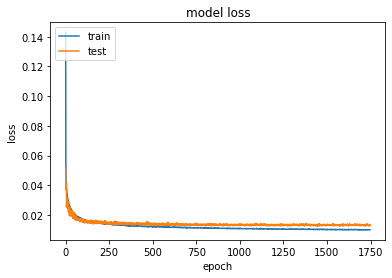

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('training_curves.png')
plt.show()

# Testing

In [15]:
y_predict = model.predict(x_test, batch_size=batch_size) 
y_predict_in_val = model.predict(x_val, batch_size=batch_size)
y_predict_in_train = model.predict(x_train, batch_size=batch_size)


Revert the Representation from normalize to lat-long coordinates

In [16]:
y_predict = scaler_y.inverse_transform(y_predict)
y_predict_in_train = scaler_y.inverse_transform(y_predict_in_train)
y_predict_in_val = scaler_y.inverse_transform(y_predict_in_val)
y_train = scaler_y.inverse_transform(y_train)
y_val = scaler_y.inverse_transform(y_val)
y_test = scaler_y.inverse_transform(y_test)

Calculate Haversine Error

In [17]:
print("Train set mean error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_train, y_train,'mean')))
print("Train set median error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_train, y_train,'median')))
print("Train set75th perc error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_train, y_train,'percentile',75)))
print("Val set mean error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_val, y_val,'mean')))
print("Val set median error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_val, y_val,'median')))
print("Val set 75th perc.  error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_val, y_val,'percentile',75)))
print("Test set mean error: {:.2f}".format(my_custom_haversine_error_stats(y_predict, y_test,'mean')))
print("Test set median error: {:.2f}".format(my_custom_haversine_error_stats(y_predict, y_test,'median')))
print("Test set  75th perc. error: {:.2f}".format(my_custom_haversine_error_stats(y_predict, y_test,'percentile',75)))


Train set mean error: 91.12
Train set median error: 31.98
Train set75th perc error: 71.51
Val set mean error: 132.99
Val set median error: 41.30
Val set 75th perc.  error: 126.85
Test set mean error: 134.11
Test set median error: 40.94
Test set  75th perc. error: 124.41


In [18]:
test_error_list = calculate_pairwise_error_list(y_predict,y_test)
p.DataFrame(test_error_list).to_csv("mlp_test_error_list.csv")
print("Experiment completed!!!")

Experiment completed!!!


In [19]:
# keras library import  for Saving and loading model and weights

from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()


with open("Baseline.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("Baseline.h5")